In [3]:
%matplotlib inline
import string
import cartopy.crs as ccrs
import pjr
import numpy as np
from timeit import default_timer as timer
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import cdms2
import cdutil
import re
import cdtime
import glob
import fnmatch
import os

SyntaxError: Missing parentheses in call to 'print'. Did you mean print("class", data2.__class__)? (pjr.py, line 196)

test latex syntax $a = b^2$

In [ ]:
# a useful function for interpolating model to new levels
def rescale (F, factor=None, myunits=None, offset=None):
    name = F.id
    if ((not offset is None) & (not factor is None)):
        print("rescale cannot set both offset and factor")
        # if you want to then exit the program
        import sys
        sys.exit(1)
    if not offset is None:
        F = F - offset;
    if not factor is None:
        F = F*Factor
    if not myunits is None:
        F.units = myunits 
    if F.id is "TREFHT":
        F = F - 273.15
        F.units = "C"
    if F.id is "TGCLDIWP":
        F = F*1.e3
        F.units = 'g/m2'
    if F.id is "TGCLDLWP":
        F = F*1.e3
        F.units = 'g/m2'
    if F.id is "BURDEN2":
        F = F*1.e6
        F.units = "mg/m2"
        
    F.id = name
    return F;

# a useful function for interpolating model to new levels
def getfld (fspec, vname, levs=None, time=None):
    """get zonal average field from model on pressure levels"""
    F =  fspec(vname,squeeze=1, time=time)            # extract fields, remove dimensions length one
    if vname is "TREFHT":
        F = F - 273.15
        F.units = "C"
    if vname is "TGCLDIWP":
        F = F*1.e3
        F.units = 'g/m2'
    if vname is "TGCLDLWP":
        F = F*1.e3
        F.units = 'g/m2'
        
    if not levs is None:
        print "interpolate to pressure levels", levs
        ps = fspec('PS',squeeze=1)
        hyam = fspec('hyam',squeeze=1)
        hybm = fspec('hybm',squeeze=1)

        start = timer()
        P = cdutil.reconstructPressureFromHybrid (ps,hyam,hybm,1.e5)
        P = P/100.; P.units = "hPa"
        stop1 = timer()
        print  "reconstruct P time = ", stop1-start
        FP1 = cdutil.logLinearInterpolation(F,P,levels=levs)
        stop2 = timer()
        print "interp time", stop2-stop1

        F = FP1

    F.id = vname
    return F;


def getdat (g0, vnameo, g1, g2, vname):
    """function to get model and obs datasets, move them to a common pressure coord grid
    returns:
        the observations (TP0xav)
        difference of model1 and obs (DT1xav)
        difference of model2 and obs (DT2xav)
    """
    T0 =  g0(vnameo,squeeze=1)            # get obs
    TM0 = g2(vname,squeeze=1) # get a model grid so we can do horizontal regrid obs
    T0 = T0.regrid(TM0.getGrid(),regridTool="esmf",regridMethod="linear") # horizontal regrid

    T1 = getfld (g1, vname)


    T2 = getfld (g2, vname)


    DT2 = T2 - T0
    DT1 = T1 - T0

    return T0, DT1, DT2;


    
# a class that can hold model and observational names 
class vsets(object):
    def __init__(self, name=None, mname=None, oname=None, hash={}) :
         self.name = name
         self.mname = mname
         self.oname = oname

    

In [3]:
from matplotlib import gridspec
import matplotlib.path as mpath
def setup3 ():
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    sbnd = 60.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    fig = plt.figure(figsize=(4, 8)) 
    gs = gridspec.GridSpec(3, 2, width_ratios=[10, 1]) 

    ax0 = plt.subplot(gs[0],projection=ccrs.NorthPolarStereo())
    ax0.set_extent([-180, 180, sbnd, 90], ccrs.PlateCarree())
    ax0.set_boundary(circle, transform=ax0.transAxes)
#   ax0.set_global() # make axis consistent with projection limits
    cx0 = plt.subplot(gs[1])
    
    ax1 = plt.subplot(gs[2],projection=ccrs.NorthPolarStereo())
    ax1.set_global() # make axis consistent with projection limits
    ax1.set_extent([-180, 180, sbnd, 90], ccrs.PlateCarree())
    ax1.set_boundary(circle, transform=ax1.transAxes)
    cx1 = plt.subplot(gs[3])
    ax2 = plt.subplot(gs[4],projection=ccrs.NorthPolarStereo())
    ax2.set_global() # make axis consistent with projection limits
    ax2.set_extent([-180, 180, sbnd, 90], ccrs.PlateCarree())
    ax2.set_boundary(circle, transform=ax2.transAxes)
    cx2 = plt.subplot(gs[5])
    return fig,[ax0,ax1,ax2],[cx0,cx1,cx2];

def setup1 ():
    fig = plt.figure(figsize=(6, 3)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1]) 
    ax0 = plt.subplot(gs[0],projection=ccrs.Orthographic(0, 90))
    ax0.set_global() # make axis consistent with projection limits
    cx0 = plt.subplot(gs[1])
    return fig,ax0,cx0;

def defset (data, plotOpt, attribute):
    """return a sensible attribute
    if data is a numpy array, the default is an empty string
    if data is a smarter object like a cdms var it looks for an attribute
        if present that becomes the default
        else default is empty string
    if plotOpt dictionary contains a value, that is the returned quantity
    """
#    print "defset searching for ", attribute
    if hasattr(data,attribute):
        defval = getattr(data,attribute)
#        print attribute, "present, defval set to", defval
        #    variance.units = '(%s)^2'%var.units
    else:
#        print "no attribute defval set empty"
        defval = None
    val = plotOpt.get(attribute,defval)
#    print "defset returning", val
    return val;


def pltframe (data, lons=None, lats=None, axo=None, cxo=None,plotOpt=None):
    """Create a robinson projection contour plot of one variable
    axo = the axes that we make the plot on 
    data = 2d numpy array (or data structure base on numpy) ordered (latitude, pressure
)
    lons = optional mesh  of longitude (same shape as data)
    lats = 1d numpy array of latitudes (")
    plotOpt is a optional dictionary with plotting options:
      'scale_factor': multiply values with this factor before plotting
      'units': a units label for the colorbar
      'clevs': use list of values as contour intervals
      'cmap': the color map to use
      'cabv': the above color
      'cbel': the below color
      'colorbar': location of colorbar ('bot','top','left','right','None')
      'rmClev': contour level to delete; frequently Zero, see findNiceContours
      'title': a title for the plot
    """
#    print "pltframe"
    if plotOpt is None: plotOpt = {}
    clevs = plotOpt.get("clevs") 
#    print "pltframe plotOpt clevs", clevs
    rmClev = plotOpt.get("rmClev")
#    print "pltframe rmClev", rmClev
    if clevs is None:
#        print "clevs undefined"
        clevs = pjr.findNiceContours(data,rmClev=rmClev)
    print "data range",data.min(), data.max()
#   print "pltframe final clevs", clevs
    cmap = plotOpt.get("cmap")
    if cmap is None:
        cmap = mpl.cm.get_cmap()
    norm = mpl.colors.BoundaryNorm(clevs,cmap.N)
    scale_factor = plotOpt.get('scale_factor', 1.0)
    pdata = data * scale_factor
    # add a title
    title = defset(data, plotOpt,"title")
    if not title is None: axo.set_title(title,loc='center')
    ltitle = defset(data, plotOpt,"ltitle")
    if not ltitle is None: axo.set_title(ltitle,loc='left')
    rtitle = defset(data, plotOpt,"rtitle")
    if not rtitle is None: axo.set_title(rtitle,loc='right')
    conout = axo.contourf(lons, lats, pdata, levels=clevs, 
        norm=norm, cmap=cmap, transform=ccrs.PlateCarree(),extend='both')
    noCbar = plotOpt.get("noCbar")
    if noCbar is None:
        cabv = plotOpt.get("cabv",'green') 
        conout.cmap.set_over(cabv)
        cbel = plotOpt.get('cbel','grey')
        conout.cmap.set_under(cbel)
        cbar = fig.colorbar(conout, cax=cxo,  orientation="vertical",ticks=clevs)
        labelFontSize = "small"
        units = defset(data, plotOpt,"units")
        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(labelFontSize)
            #cbar.set_label(units)
        if not units is None: cbar.ax.set_title('('+units+')',pad=5)
    else:
        cxo.axis('off')
 
    axo.coastlines()
    axo.gridlines()
#    print"pltframe done"

def pltdat(T1, T2, DT):
    cmap = plt.cm.viridis
    lons = T1.getLongitude()
    lats = T1.getLatitude()
#    print TP0.info()
    dtrng = np.array([T1.min(),T2.min(),T1.max(), T2.max()])
    clevs = pjr.findNiceContours(dtrng)
    
    pltframe(T2, lons, lats, ax3[0], cx3[0], 
             plotOpt={'cmap':cmap,'ltitle':ltit2,'clevs':clevs,'rtitle':rtit2,'cbel':'grey','cabv':'orange'})

    pltframe(T1, lons, lats, ax3[1], cx3[1], 
             plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})
    cmap = pjr.diverge_map()
    dlevs = pjr.findNiceContours(DT,nlevs=12,rmClev=0.,sym=True)
#    print "T1.info", T1.info()
#    print "DT info", DT.info()
    print "DT.id", DT.id
    if DT.id == 'LWCF':
        dlevs = [-5.,4.,-3.,-2.,-1.,1.,2.,3.,4.,5.]
    if DT.id == 'SWCF':
        dlevs = [-10.,-8.,-6.,-4.,-2.,2.,4.,6.,8.,10.]
    if DT.id == 'TS':
        dlevs = [-1.,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.]
    if DT.id == 'TGCLDIWP':
        dlevs = [-5.,-2.,-1.,1.,2.,5.]
        
    dtitle = ltitD
    pltframe(DT, lons, lats, ax3[2], cx3[2], 
             plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})

def pltdat1(T1, T2, DT):
#   just do one frame
    cmap = plt.cm.viridis
    lons = T1.getLongitude()
    lats = T1.getLatitude()
#    print TP0.info()
    dtrng = np.array([T1.min(),T2.min(),T1.max(), T2.max()])
    clevs = pjr.findNiceContours(dtrng)
    
#    pltframe(T2, lons, lats, ax3[0], cx3[0], 
#             plotOpt={'cmap':cmap,'ltitle':ltit2,'clevs':clevs,'rtitle':rtit2,'cbel':'grey','cabv':'orange'})

#    pltframe(T1, lons, lats, ax3[1], cx3[1], 
#             plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})
    cmap = pjr.diverge_map()
    dlevs = pjr.findNiceContours(DT,nlevs=12,rmClev=0.,sym=True)
#    print "T1.info", T1.info()
#    print "DT info", DT.info()

    print "DT.id", DT.id
    if DT.id == 'LWCF':
        dlevs = [-5.,-4.,-3.,-2.,-1.,1.,2.,3.,4.,5.]
    if DT.id == 'SWCF':
        dlevs = [-10.,-8.,-6.,-4.,-2.,2.,4.,6.,8.,10.]
    if DT.id == 'TS':
        dlevs = [-1.,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.]
    if DT.id == 'TGCLDIWP':
        dlevs = [-5.,-2.,-1.,1.,2.,5.]
    if DT.id == 'FSNT':
        dlevs = [-15.,-10.,-5.,-2.,-1.,1.,2.,5.,10.,15.]
        
    dtitle = ltitD
    pltframe(DT, lons, lats, ax1, cx1, 
             plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})


In [2]:
# a cell in preparation to do the real model intercomparison
# a rigorous decomposition of fields over land, ocean and sea ice, 
# and assessment of implications of masking
# note that all these results depend upon 
# when during processing you apply the weighting and masking

# a list of variables and the names they are called in the model and obs dataset files
vlist = [] #create an empty list

#vlist.append(vsets('TGCLDLWP', 'TGCLDLWP','TGCLDLWP'))
#vlist.append(vsets('TGCLDIWP', 'TGCLDIWP','TGLDLIWP'))

#vlist.append(vsets("FSNT", "FSNT","FSNT"))
#vlist.append(vsets("FLNS", "FLNS","FLNS"))
vlist.append(vsets("TMQ", "TMQ","TMQ"))
#vlist.append(vsets("SST", "SST","SST"))
#vlist.append(vsets("FSNTC", "FSNTC","FSNTC"))
#vlist.append(vsets("FLNT", "FLNT","FLNT"))
#vlist.append(vsets("FLNTC", "FLNTC","FLNTC"))
#vlist.append(vsets('TREFHT', 'TREFHT','TREFHT'))
#vlist.append(vsets('LWCF', 'LWCF','LWCF'))
#vlist.append(vsets("Aer Opt Depth", "AEROD_v","AEROD_v"))
#vlist.append(vsets("Solar Insolation", "SOLIN", "SOLIN"))
#vlist.append(vsets("Surface Temperature", "TS", "tsrf"))
#vlist.append(vsets('SWCF', 'SWCF','SWCF'))
#vlist.append(vsets('CLDTOT', 'CLDTOT','CLDTOT'))
#vlist.append(vsets('CLDLOW', 'CLDLOW','CLDLOW'))
#vlist.append(vsets('CLDMED', 'CLDMED','CLDMED'))
#vlist.append(vsets('CLDHGH', 'CLDHGH','CLDHGH'))


def nameSort(e):
    return e.name

vlist.sort(key=nameSort)

#vlist.append(vsets("Precipitation", "PRECL","PRECL"))
#vlist.append(vsets("", "U", "ua"))
 
seaslist = ["ANN","JJA","DJF"]
seaslist = ["JAN"]

NameError: name 'vsets' is not defined

In [57]:
# identify fields to be evaluated

mon = "01"
if 1 == 1:
    # model2 dataset (the experiment)
    dir2 = "/dtemp/st49401/d3x345/yotc_f02_pdil_sat_"+mon+"/atm/hist/"
#    dir2 = "/dtemp/st49401/zhan686/yotc/f02/yotc_f02_pdil_sat_"+mon+"/atm/hist/"
    files = fnmatch.filter(os.listdir(dir2), "*cam.h1.2009-"+mon+"*00.nc")
#    print "files", files
    
    # the "reference" dataset
    dir1 = "/dtemp/st49401/d3x345/yotc_f02_pdil_sat_"+mon+"/atm/hist/"
#    dir1 = "/dtemp/st49401/zhan686/yotc/f02/yotc_f02_pdil_sat_"+mon+"/atm/hist/"
    f1 = "yotc_f02_pdil_sat_"+mon+".cam.h0.2009-"+mon+".nc"
    jname1 = dir1+f1
    print "jname1 ", jname1
    
#   print "all",files
#    files = files

#files = {files[0]} # select only the first file for debugging   
for f2 in files:
    #print "f2 is ", f2
    print(f2)

jname1  /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h0.2009-01.nc
yotc_f02_pdil_sat_01.cam.h1.2009-01-18-21600.nc
yotc_f02_pdil_sat_01.cam.h1.2009-01-12-21600.nc
yotc_f02_pdil_sat_01.cam.h1.2009-01-06-21600.nc
yotc_f02_pdil_sat_01.cam.h1.2009-01-11-21600.nc
yotc_f02_pdil_sat_01.cam.h1.2009-01-09-21600.nc
yotc_f02_pdil_sat_01.cam.h1.2009-01-29-21600.nc
yotc_f02_pdil_sat_01.cam.h1.2009-01-07-21600.nc
yotc_f02_pdil_sat_01.cam.h1.2009-01-03-21600.nc
yotc_f02_pdil_sat_01.cam.h1.2009-01-02-21600.nc
yotc_f02_pdil_sat_01.cam.h1.2009-01-05-21600.nc
yotc_f02_pdil_sat_01.cam.h1.2009-01-08-21600.nc
yotc_f02_pdil_sat_01.cam.h1.2009-01-21-21600.nc
yotc_f02_pdil_sat_01.cam.h1.2009-01-15-21600.nc
yotc_f02_pdil_sat_01.cam.h1.2009-01-28-21600.nc
yotc_f02_pdil_sat_01.cam.h1.2009-01-30-21600.nc
yotc_f02_pdil_sat_01.cam.h1.2009-01-22-21600.nc
yotc_f02_pdil_sat_01.cam.h1.2009-01-31-21600.nc
yotc_f02_pdil_sat_01.cam.h1.2009-01-19-21600.nc
yotc_f02_pdil_sat_01.cam.h1.2009-01-2

processing time average
reference dataset is jname1 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h0.2009-01.nc
processing timeslice from dir2  /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/
jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-18-21600.nc
figure being saved to  workdir/TMQ_2009_01_18h06_R.pdf
data range 0.346237 19.31756
data range 0.8182943 12.1790905
dtrng [0.         5.16908741]
dlevs1 [-2.5 -2.  -1.5 -1.  -0.5  0.5  1.   1.5  2.   2.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.20039988 5.1690874


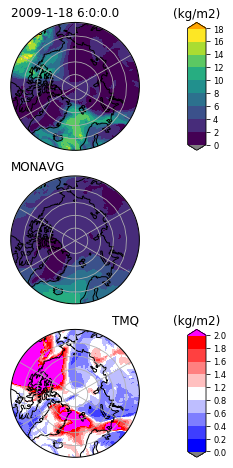

done with time 2009_01_18h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-12-21600.nc
figure being saved to  workdir/TMQ_2009_01_12h06_R.pdf
data range 0.17640531 19.317905
data range 0.8182943 12.1790905
dtrng [0.         2.76908326]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.09516605 2.7690833


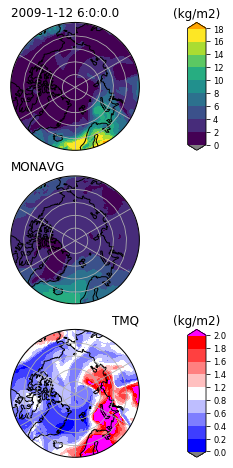

done with time 2009_01_12h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-06-21600.nc
figure being saved to  workdir/TMQ_2009_01_06h06_R.pdf
data range 0.4564227 23.022642
data range 0.8182943 12.1790905
dtrng [0.        3.7320776]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.12603463 3.7320776


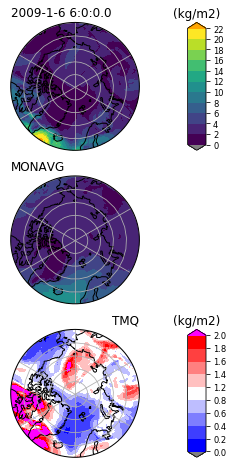

done with time 2009_01_06h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-11-21600.nc
figure being saved to  workdir/TMQ_2009_01_11h06_R.pdf
data range 0.1623463 20.551407
data range 0.8182943 12.1790905
dtrng [0.         2.73419595]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.13572435 2.734196


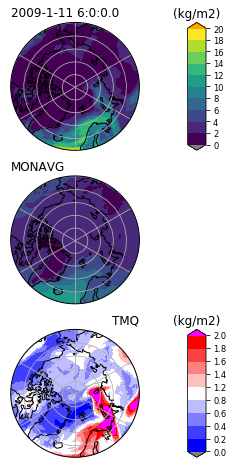

done with time 2009_01_11h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-09-21600.nc
figure being saved to  workdir/TMQ_2009_01_09h06_R.pdf
data range 0.22438544 19.141628
data range 0.8182943 12.1790905
dtrng [0.         2.48249841]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.13354884 2.4824984


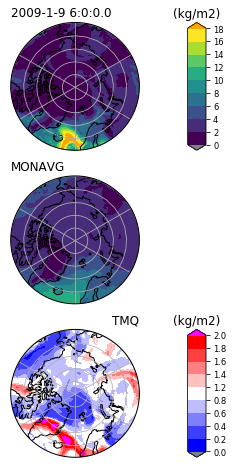

done with time 2009_01_09h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-29-21600.nc
figure being saved to  workdir/TMQ_2009_01_29h06_R.pdf
data range 0.37842253 17.238808
data range 0.8182943 12.1790905
dtrng [0.       3.426162]
dlevs1 [-1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2
  1.4  1.6]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.1837856 3.426162


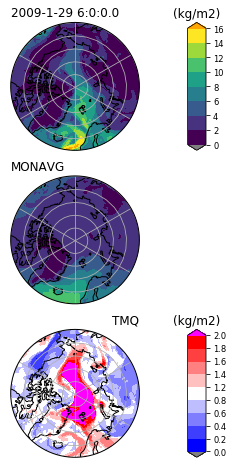

done with time 2009_01_29h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-07-21600.nc
figure being saved to  workdir/TMQ_2009_01_07h06_R.pdf
data range 0.27351862 22.217863
data range 0.8182943 12.1790905
dtrng [0.         3.07312918]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.106009476 3.0731292


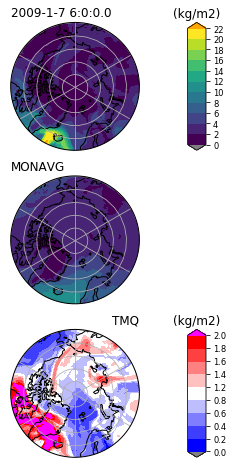

done with time 2009_01_07h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-03-21600.nc
figure being saved to  workdir/TMQ_2009_01_03h06_R.pdf
data range 0.5844703 21.206673
data range 0.8182943 12.1790905
dtrng [0.         4.96446419]
dlevs1 [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.1539333 4.964464


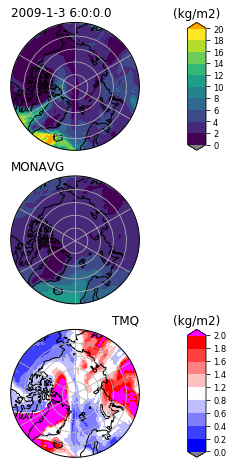

done with time 2009_01_03h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-02-21600.nc
figure being saved to  workdir/TMQ_2009_01_02h06_R.pdf
data range 0.60135007 23.135149
data range 0.8182943 12.1790905
dtrng [0.         5.68646765]
dlevs1 [-2.5 -2.  -1.5 -1.  -0.5  0.5  1.   1.5  2.   2.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.18949972 5.6864676


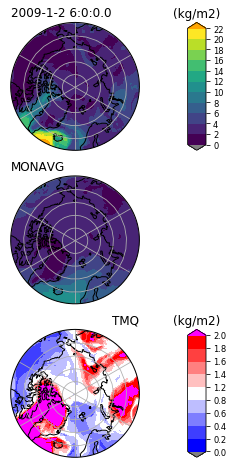

done with time 2009_01_02h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-05-21600.nc
figure being saved to  workdir/TMQ_2009_01_05h06_R.pdf
data range 0.21931385 18.515646
data range 0.8182943 12.1790905
dtrng [0.        3.7345922]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.122800566 3.7345922


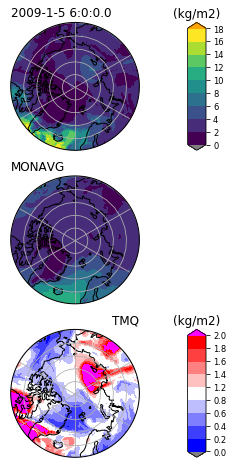

done with time 2009_01_05h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-08-21600.nc
figure being saved to  workdir/TMQ_2009_01_08h06_R.pdf
data range 0.23290482 19.732855
data range 0.8182943 12.1790905
dtrng [0.         2.79234624]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.12072652 2.7923462


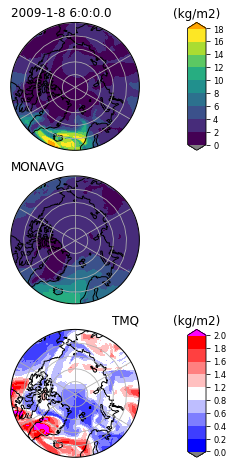

done with time 2009_01_08h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-21-21600.nc
figure being saved to  workdir/TMQ_2009_01_21h06_R.pdf
data range 0.54051495 13.857387
data range 0.8182943 12.1790905
dtrng [0.         3.20978284]
dlevs1 [-1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2
  1.4  1.6]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.15464254 3.2097828


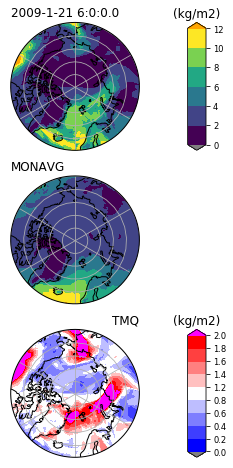

done with time 2009_01_21h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-15-21600.nc
figure being saved to  workdir/TMQ_2009_01_15h06_R.pdf
data range 0.2028476 20.412754
data range 0.8182943 12.1790905
dtrng [0.         5.28160191]
dlevs1 [-2.5 -2.  -1.5 -1.  -0.5  0.5  1.   1.5  2.   2.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.07793004 5.281602


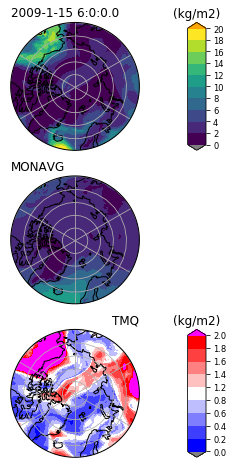

done with time 2009_01_15h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-28-21600.nc
figure being saved to  workdir/TMQ_2009_01_28h06_R.pdf
data range 0.41979024 15.631841
data range 0.8182943 12.1790905
dtrng [0.         3.31276917]
dlevs1 [-1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2
  1.4  1.6]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.19400741 3.3127692


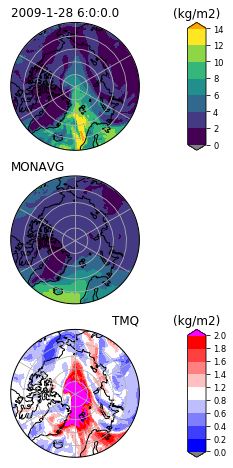

done with time 2009_01_28h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-30-21600.nc
figure being saved to  workdir/TMQ_2009_01_30h06_R.pdf
data range 0.3715932 21.146854
data range 0.8182943 12.1790905
dtrng [0.         3.25344658]
dlevs1 [-1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2
  1.4  1.6]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.15438513 3.2534466


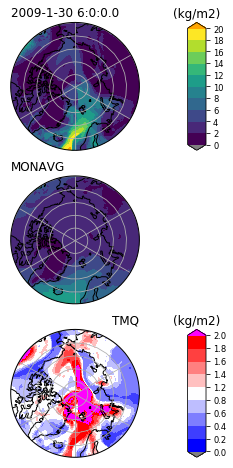

done with time 2009_01_30h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-22-21600.nc
figure being saved to  workdir/TMQ_2009_01_22h06_R.pdf
data range 0.33442676 17.843119
data range 0.8182943 12.1790905
dtrng [0.         3.11116648]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.12602845 3.1111665


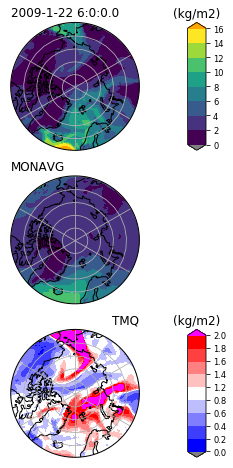

done with time 2009_01_22h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-31-21600.nc
figure being saved to  workdir/TMQ_2009_01_31h06_R.pdf
data range 0.36328092 20.627996
data range 0.8182943 12.1790905
dtrng [0.         3.03053999]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.16464156 3.03054


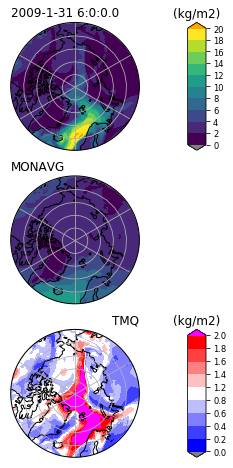

done with time 2009_01_31h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-19-21600.nc
figure being saved to  workdir/TMQ_2009_01_19h06_R.pdf
data range 0.21689554 18.43753
data range 0.8182943 12.1790905
dtrng [0.         5.02140713]
dlevs1 [-2.5 -2.  -1.5 -1.  -0.5  0.5  1.   1.5  2.   2.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.1835187 5.021407


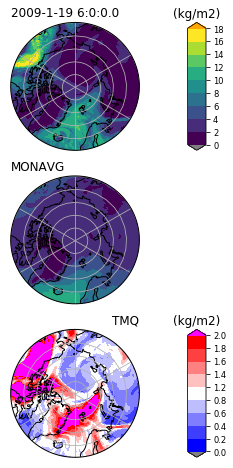

done with time 2009_01_19h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-23-21600.nc
figure being saved to  workdir/TMQ_2009_01_23h06_R.pdf
data range 0.26271892 15.0733385
data range 0.8182943 12.1790905
dtrng [0.        3.5092907]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.11193298 3.5092907


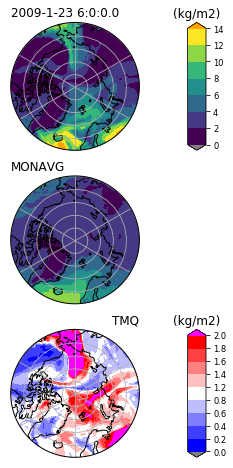

done with time 2009_01_23h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-25-21600.nc
figure being saved to  workdir/TMQ_2009_01_25h06_R.pdf
data range 0.40228873 15.321581
data range 0.8182943 12.1790905
dtrng [0.         2.46781588]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.15722634 2.4678159


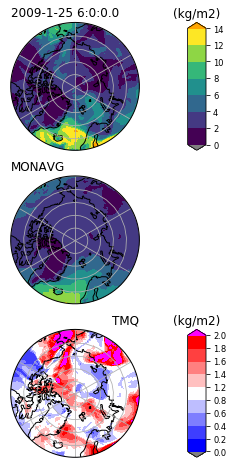

done with time 2009_01_25h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-16-21600.nc
figure being saved to  workdir/TMQ_2009_01_16h06_R.pdf
data range 0.16663042 19.767319
data range 0.8182943 12.1790905
dtrng [0.         5.59663725]
dlevs1 [-2.5 -2.  -1.5 -1.  -0.5  0.5  1.   1.5  2.   2.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.081761904 5.5966372


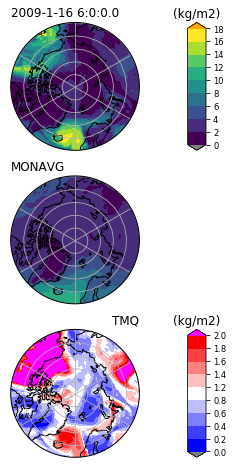

done with time 2009_01_16h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-27-21600.nc
figure being saved to  workdir/TMQ_2009_01_27h06_R.pdf
data range 0.3841158 16.426811
data range 0.8182943 12.1790905
dtrng [0.         2.91375947]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.2986844 2.9137595


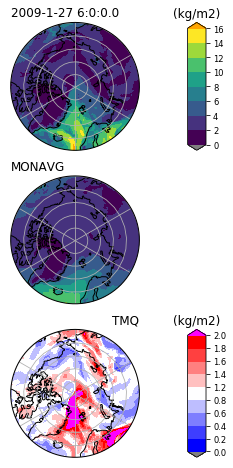

done with time 2009_01_27h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-01-21600.nc
figure being saved to  workdir/TMQ_2009_01_01h06_R.pdf
data range 0.48988146 22.813301
data range 0.8182943 12.1790905
dtrng [0.         4.84922171]
dlevs1 [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.13773987 4.8492217


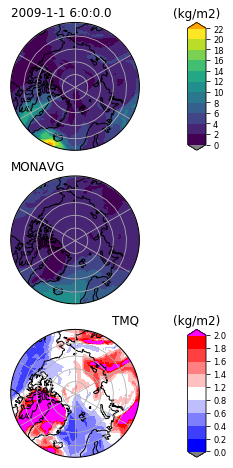

done with time 2009_01_01h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-17-21600.nc
figure being saved to  workdir/TMQ_2009_01_17h06_R.pdf
data range 0.19396172 16.402636
data range 0.8182943 12.1790905
dtrng [0.         4.64111042]
dlevs1 [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.13952059 4.6411104


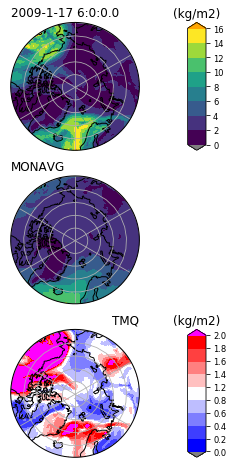

done with time 2009_01_17h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-14-21600.nc
figure being saved to  workdir/TMQ_2009_01_14h06_R.pdf
data range 0.223081 22.121042
data range 0.8182943 12.1790905
dtrng [0.         3.51579094]
dlevs1 [-1.5 -1.  -0.5  0.5  1.   1.5]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.10622551 3.515791


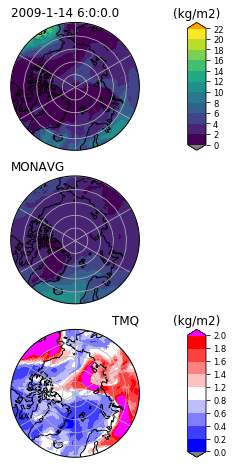

done with time 2009_01_14h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-20-21600.nc
figure being saved to  workdir/TMQ_2009_01_20h06_R.pdf
data range 0.4007568 14.628551
data range 0.8182943 12.1790905
dtrng [0.        4.2509017]
dlevs1 [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.10846638 4.2509017


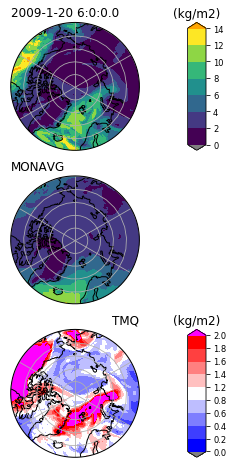

done with time 2009_01_20h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-24-21600.nc
figure being saved to  workdir/TMQ_2009_01_24h06_R.pdf
data range 0.37552574 14.31302
data range 0.8182943 12.1790905
dtrng [0.         3.11197686]
dlevs1 [-1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2  1.4]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.14644456 3.1119769


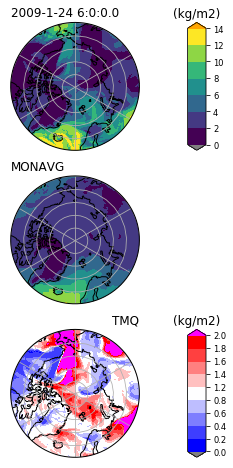

done with time 2009_01_24h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-10-21600.nc
figure being saved to  workdir/TMQ_2009_01_10h06_R.pdf
data range 0.18141694 19.420057
data range 0.8182943 12.1790905
dtrng [0.         2.14859343]
dlevs1 [-1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.14982125 2.1485934


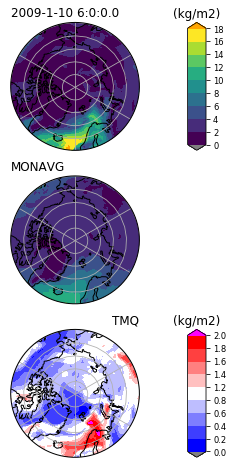

done with time 2009_01_10h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-04-21600.nc
figure being saved to  workdir/TMQ_2009_01_04h06_R.pdf
data range 0.41008967 19.000095
data range 0.8182943 12.1790905
dtrng [0.         4.46807194]
dlevs1 [-2.  -1.5 -1.  -0.5  0.5  1.   1.5  2. ]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.14315759 4.468072


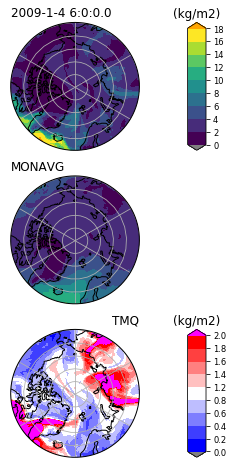

done with time 2009_01_04h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-26-21600.nc
figure being saved to  workdir/TMQ_2009_01_26h06_R.pdf
data range 0.3526622 16.420246
data range 0.8182943 12.1790905
dtrng [0.         2.58998299]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.26118773 2.589983


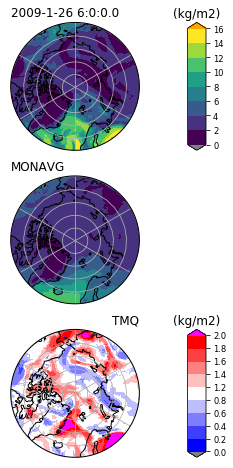

done with time 2009_01_26h06



jname2 /dtemp/st49401/d3x345/yotc_f02_pdil_sat_01/atm/hist/yotc_f02_pdil_sat_01.cam.h1.2009-01-13-21600.nc
figure being saved to  workdir/TMQ_2009_01_13h06_R.pdf
data range 0.19562748 14.248517
data range 0.8182943 12.1790905
dtrng [0.         2.75922894]
dlevs1 [-1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.2  0.4  0.6  0.8  1.   1.2]
final ratio plot dlevs [0.  0.2 0.4 0.6 0.8 1.2 1.4 1.6 1.8 2. ]
data range 0.10555084 2.759229


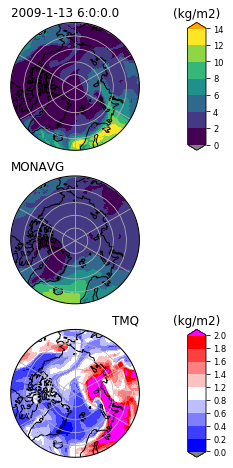

done with time 2009_01_13h06



all done


In [58]:
if 1 == 1:

    plottype = "DIFF"
    plottype = "RATIO"
    dfact = 0.5  # multiplier on contour levels for anomalies
    dfact = 1.0  
    dfact = 0.5
    vname = "BURDEN2"
    vname = "TMQ"
    
    print "processing time average"
# model1 dataset (the reference)

    title1 = "MONAVG"
    ltit1 = title1  
    rtit1 = ""
    

    g1 = cdms2.open(jname1);
    print "reference dataset is jname1", jname1  

#    varlist2 = g2.listvariables();
#   varlist = [x for x in varlist if re.match(r'^.*CLD.*',x)]
#    print "g2 varlist", varlist2
#    dims2 = g2.listdimension();
#    print "g2 dims", dims2    
    

    T1 = getfld(g1,vname,time=slice(0,1)) # first time slice
    T1 = rescale(T1);
#    print "T1 shape", T1.shape

print "processing timeslice from dir2 ", dir2
for f2 in files:
    # model2 dataset (the experiment) 
    jname2 = dir2+f2
    g2 = cdms2.open(jname2);
    print "jname2", jname2
    varlist = g2.listvariables();
#   varlist = [x for x in varlist if re.match(r'^.*CLD.*',x)]
#    print "g2 varlist", varlist
    dims = g2.listdimension();
#   print "j2 dims"
    dims = g2.listdimension();
    tindex = dims.index('time')
#   print "tindex", tindex
    diminfo = g2[dims[tindex]].attributes
    #xx = g2[dims[tindex]].asComponentTime()
    #print "xx",xx
#    print "diminfo", diminfo
    timeunits = diminfo['units']
    #print "timeunits", timeunits
    times = g2[dims[tindex]][:]
    #print "times", times
    starttime = g2[dims[tindex]][0]
    #print "starttime", starttime
    
#if 1 == 1:
    thistime = times[0]
#for thistime in times:
    #print "thistime", thistime

    #T2 = getfld(g2,vname,time=slice(0,1))
    T2 = getfld(g2,vname,time=thistime)
    T2 = rescale(T2)
    rt = cdtime.reltime(thistime, timeunits)
    #print "rt", rt
    ct = rt.tocomp()
    #help(ct)
    #print "ct", ct

    title2 = "{:.2f}".format(thistime)
    title2 = ct
    ltit2 = title2
    rtit2 = ""
 
# if 1 == 1:
    sbnd = 60.
    T1 = T1.subRegion(latitude=(sbnd,90.))
    T2 = T2.subRegion(latitude=(sbnd,90.))


#    T2 = getfld(g2,"QV")
#    DELP = getfld(g2,'DELP')
#    T2V = T2*DELP/9.806

#    T2V = cdutil.averager(T2V,axis="t",weights='unweighted')
#    T2V = cdutil.averager(T2V,axis="z",weights='equal', action='sum')
#    print "range", T2V.min(), T2V.max()
#    pltframe(T2V, lons, lats, ax3[0], cx3[0])    
#    T2 = T2V    

    if plottype == "DIFF":
        DT = T2 - T1
    else:
        DT = T2/T1
        
    DT.id = T1.id

    ctstring = "{:04d}_{:02d}_{:02d}h{:02d}".format(ct.year, ct.month, ct.day, ct.hour)
    if plottype == "DIFF":
        pltname = "workdir/"+vname+"_"+ctstring+"_D.pdf"
    else:
        pltname = "workdir/"+vname+"_"+ctstring+"_R.pdf"
        
    lons = T1.getLongitude()
    lats = T1.getLatitude()
#   pltframe(T1, lons, lats, ax3[1], cx3[1])# , 
    #plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})

    print "figure being saved to ", pltname
    fig, ax3, cx3 = setup3()
#    pltframe(DT, lons, lats, ax3[2], cx3[2]) #, 
    #  plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})    


    cmap = plt.cm.viridis

#    print "plotting MERRA2"
#    print TP0.info()
    dtrng = np.array([T1.min(),T2.min(),T1.max(), T2.max()])
    clevs = pjr.findNiceContours(dtrng)
    if T1.id == "BURDEN2":
        clevs = np.array([0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0])*0.1
    
    pltframe(T2, lons, lats, ax3[0], cx3[0], 
             plotOpt={'cmap':cmap,'ltitle':ltit2,'clevs':clevs,'rtitle':rtit2,'cbel':'grey','cabv':'orange'})

#    print "plotting E3SM"
    pltframe(T1, lons, lats, ax3[1], cx3[1], 
             plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})

    cmap = pjr.diverge_map()
#   cmap = plt.cm.viridis
    

#    print "T1.info", T1.info()
#    print "DT info", DT.info()

#    print "DT.id", DT.id
    if plottype == "DIFF":
        dlevs = pjr.findNiceContours(DT,nlevs=12,rmClev=0.,sym=True)
        if DT.id == 'LWCF':
            dlevs = [-5.,-4.,-3.,-2.,-1.,1.,2.,3.,4.,5.]
        if DT.id == 'SWCF':
            dlevs = [-10.,-8.,-6.,-4.,-2.,2.,4.,6.,8.,10.]
        if DT.id == 'TS':
            dlevs = [-1.,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.]
        if DT.id == 'TGCLDIWP':
            dlevs = [-5.,-2.,-1.,1.,2.,5.]
        if DT.id == 'FSNT':
            dlevs = [-15.,-10.,-5.,-2.,-1.,1.,2.,5.,10.,15.]
        if DT.id == 'BURDEN1':
            #    dlevs = np.array([0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.])*dfact
            dlevs = np.array([-0.2,-0.10,-0.05,-0.02, 0.02, 0.05,0.1,0.2])
        if DT.id == 'BURDEN2':
            #    dlevs = np.array([0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.])*dfact
            dlevs = np.array([-0.2,-0.10,-0.05,-0.02, 0.02, 0.05,0.1,0.2])


    else:
        # ratio plots
        dtrng = np.array([0.,DT.max()])
        print "dtrng", dtrng
        dtrng = dtrng*0.5
        dlevs = pjr.findNiceContours(dtrng,nlevs=12,rmClev=0, sym=True)
        print "dlevs1", dlevs
        dlevs = (dlevs + dlevs.max())
        if DT.id == 'BURDEN1':
            dlevs = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.2,1.3,1.4,1.5,1.6,1.7,1.8,2.0])
        if DT.id == 'BURDEN2':
            #    dlevs = np.array([0.,0.5,1.,1.5,2.,2.5,3.,3.5,4.,4.5,5.])*dfact
            dlevs = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,1.2,1.3,1.4,1.5,1.6,1.7,1.8,2.0])
        if DT.id == 'TMQ':
            dlevs = np.array([0.,0.2,0.4,0.6,0.8,1.2,1.4,1.6,2.0,4.0])
            print "final ratio plot dlevs", dlevs
    
    dtitle = ""
    rtitD = vname
    pltframe(DT, lons, lats, ax3[2], cx3[2], 
             plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})

    
    plt.savefig(pltname,type="pdf",bbox_inches='tight')
    x = plt.show()

    print "done with time "+ctstring+"\n\n\n"


print "all done"